<a href="https://colab.research.google.com/github/someDeveloperDH/game/blob/dohyeon/RSP_CNN_dohyeon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2024-1학기 딥러닝 - 기말 팀 프로젝트
## **가위 바위 보 분류하기(RPS Classification)**
   

T1 (박동혁, 이유준, 배도현)

**1차 모델의 문제점 및 개선 방안**

#### 1. 모델의 문제점

- Training & Validation Accuracy 그래프에서,   
Training accracy는 높으나 Validation accuracy는 낮은 경향을 보임   
   
- Training & Validation Loss 그래프에서,   
Training loss는 낮으나 Validation loss는 높은 경향을 보임   

    
**따라서**   
모델이 Training Data에 과적합 되었음을 알 수 있다.

결국 Test Accuracy 그래프와 Test Loss 그래프에서 볼 수 있듯,    
모델 성능이 매우 좋지 않았다.

#### 2 개선 방안

일반적으로 과적합 상황에서 CNN 모델을 개선할 수 있는 방안은 다음과 같다.
1. 학습 데이터 양 증대 및 전처리 개선
2. 모델의 복잡도 조정 혹은 전이 학습
3. 정규화 기법 사용(드롭아웃, 배치 정규화 등)
4. 하이퍼파라미터 조정
5. Loss Function과 Optimizer 변경
6. 앙상블

### < 개선과정 - 데이터 증강 및 전이 학습>

전이 학습을 위한 모델로 Inception V4와 ResNet을 Ensemble 한 모델을 시도하였다.

####  학습 준비


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from random import shuffle
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##### Data 경로 설정

In [3]:
# 필요시 경로 수정 필수
base_dir = "/content/drive/MyDrive/RPS"

train_dir = os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"test")

train_paper_dir = os.path.join(train_dir,"paper") # 각 650개
train_rock_dir = os.path.join(train_dir,"rock")
train_scissors_dir = os.path.join(train_dir,"scissors")

test_paper_dir = os.path.join(test_dir,"paper") # 각 90개
test_rock_dir = os.path.join(test_dir,"rock")
test_scissors_dir = os.path.join(test_dir,"scissors")

print(f"훈련 이미지 개수 (paper): {len(os.listdir(train_paper_dir))}")
print(f"훈련 이미지 개수 (rock): {len(os.listdir(train_rock_dir))}")
print(f"훈련 이미지 개수 (scissors): {len(os.listdir(train_scissors_dir))}")

print(f"테스트 이미지 개수 (paper): {len(os.listdir(test_paper_dir))}")
print(f"테스트 이미지 개수 (rock): {len(os.listdir(test_rock_dir))}")
print(f"테스트 이미지 개수 (scissors): {len(os.listdir(test_scissors_dir))}")

훈련 이미지 개수 (paper): 650
훈련 이미지 개수 (rock): 650
훈련 이미지 개수 (scissors): 650
테스트 이미지 개수 (paper): 90
테스트 이미지 개수 (rock): 90
테스트 이미지 개수 (scissors): 90


####  Data 전처리

In [4]:
# Data Augmentation 적용
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255,
    validation_split=0.3
)



test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
batch_size = 32
test_batch_size = batch_size * 2
target_size = (224, 224) # input image size

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    subset='training',  # subset 미설정 시 분리되지 않음
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    target_size=target_size)

validation_generator = train_datagen.flow_from_directory(train_dir,
                                                         subset='validation',
                                                              batch_size=batch_size,
                                                              color_mode='rgb',
                                                              class_mode='categorical',
                                                              target_size=target_size)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=64,
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  target_size=target_size)

print(f"훈련 이미지 개수: {train_generator.samples}")
print(f"검증 이미지 개수: {validation_generator.samples}")
print(f"테스트 이미지 개수: {test_generator.samples}")

Found 1365 images belonging to 3 classes.
Found 585 images belonging to 3 classes.
Found 270 images belonging to 3 classes.
훈련 이미지 개수: 1365
검증 이미지 개수: 585
테스트 이미지 개수: 270


In [6]:
# 폴더기준으로 자동으로 클래스 나눈거 확인
train_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

####  모델 생성

Base Model로 InceptionV3를 이용하고, 가져온 모델은 학습시키지 않게 한다.

In [7]:
base_model_InceptionV3 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model_InceptionV3.trainable = True
fine_tune_at = 100

for layer in base_model_InceptionV3.layers[:fine_tune_at]:
    layer.trainable = False


87910968/87910968 [==============================] - 5s 0us/step


In [8]:
model = tf.keras.models.Sequential([
    base_model_InceptionV3,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 2048)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 batch_normalization_94 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 64)                0

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=10,
    epochs=94,
    validation_steps=10,
    verbose=1)

Epoch 1/94
10/10 [==============================] - 316s 29s/step - loss: 1.6680 - accuracy: 0.3875 - val_loss: 2.7313 - val_accuracy: 0.3719
Epoch 2/94
10/10 [==============================] - 178s 19s/step - loss: 1.2866 - accuracy: 0.4875 - val_loss: 2.9511 - val_accuracy: 0.3594
Epoch 3/94
10/10 [==============================] - 99s 10s/step - loss: 1.0918 - accuracy: 0.5312 - val_loss: 2.4779 - val_accuracy: 0.4156
Epoch 4/94
10/10 [==============================] - 62s 6s/step - loss: 0.7730 - accuracy: 0.6594 - val_loss: 2.1055 - val_accuracy: 0.4750
Epoch 5/94
10/10 [==============================] - 48s 5s/step - loss: 0.6792 - accuracy: 0.7411 - val_loss: 1.7710 - val_accuracy: 0.5344
Epoch 6/94
10/10 [==============================] - 37s 4s/step - loss: 0.6487 - accuracy: 0.7379 - val_loss: 1.5801 - val_accuracy: 0.6031
Epoch 7/94
10/10 [==============================] - 30s 3s/step - loss: 0.5844 - accuracy: 0.7750 - val_loss: 1.3252 - val_accuracy: 0.6656
Epoch 8/94
10/1

In [12]:
model.evaluate(validation_generator)

19/19 [==============================] - 13s 688ms/step - loss: 0.0977 - accuracy: 0.9709


[0.09766726195812225, 0.9709401726722717]

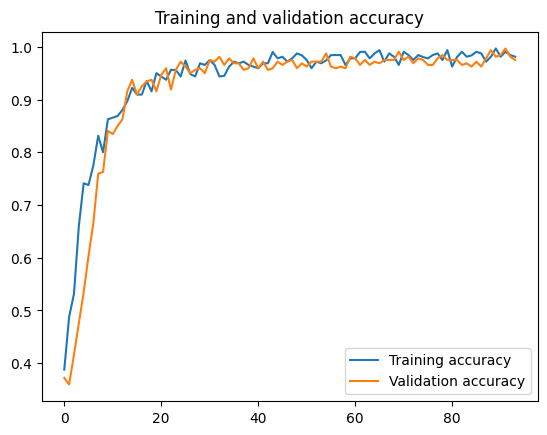

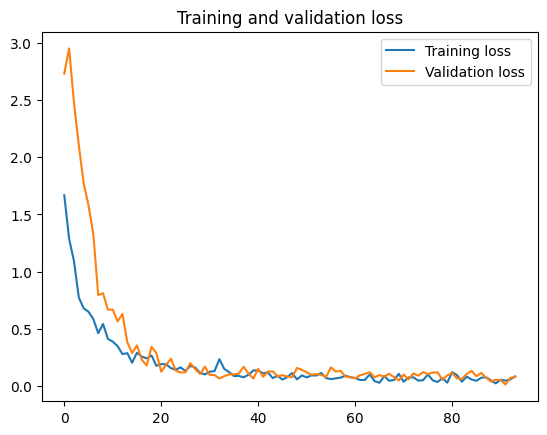

In [13]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2/2 [==============================] - 2s 102ms/step


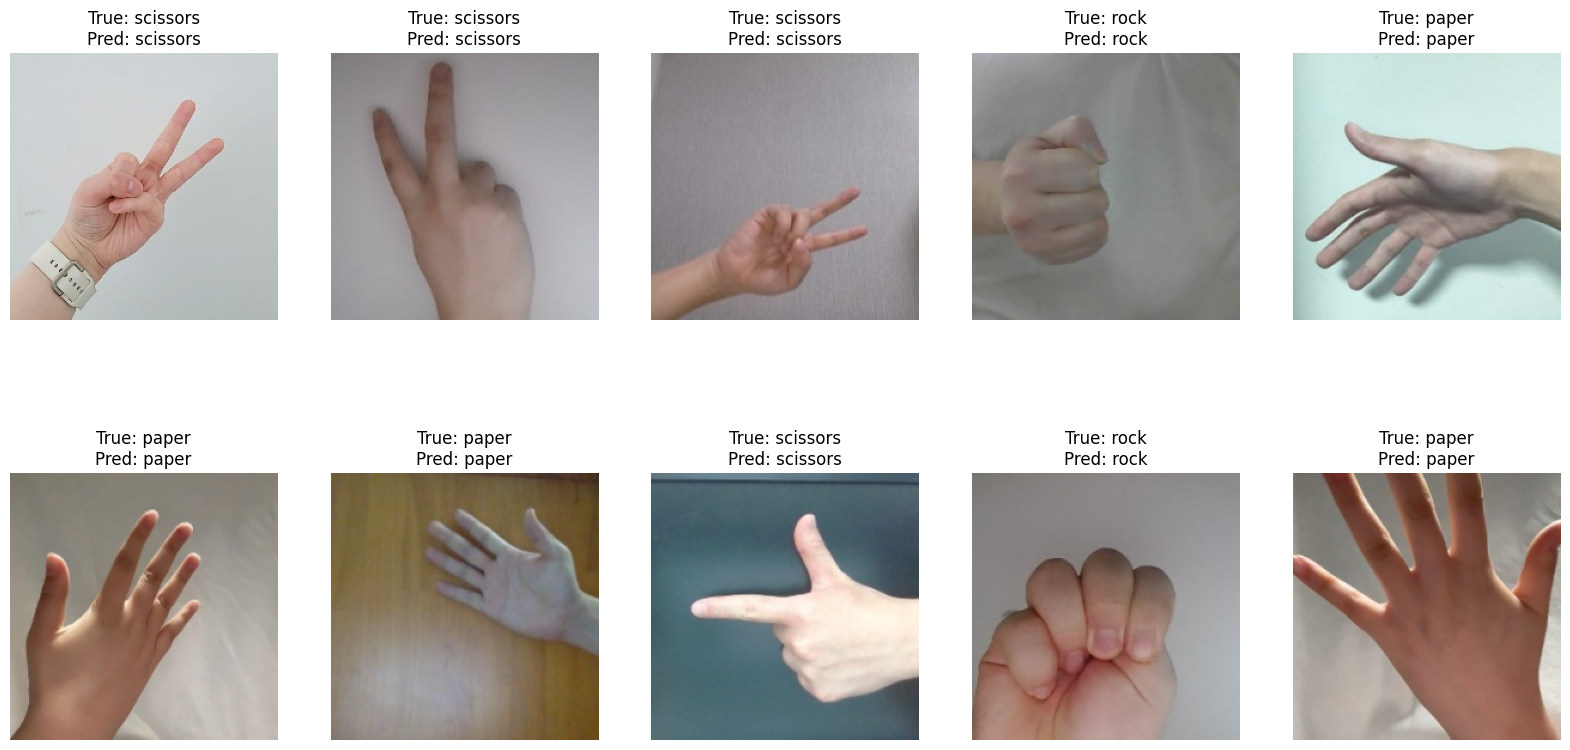

In [14]:
# 테스트 데이터셋에서 샘플 이미지와 예측 결과 시각화
def plot_images_with_predictions(generator, model, num_images=10):
    # Get a batch of images and labels
    images, labels = next(generator)

    # Make predictions
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)

    class_labels = list(generator.class_indices.keys())

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        true_label = class_labels[true_labels[i]]
        predicted_label = class_labels[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()

# 새로운 데이터 배치를 얻기 위해 제너레이터를 반복
plot_images_with_predictions(test_generator, model, num_images=10)

In [15]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


5/5 [==============================] - 137s 33s/step - loss: 0.0811 - accuracy: 0.9704
Test Accuracy: 97.04%
